In [25]:
import numpy as np

# Генерируем полное облако точек внутри куба со стороной 1
def generate_full_cube(num_points=10000):
    # равномерно распределяем точки внутри куба [-0.5, 0.5] по каждой оси
    points = np.random.uniform(-0.5, 0.5, size=(num_points, 3))
    return points

full_cube = generate_full_cube()

In [30]:
points = full_cube

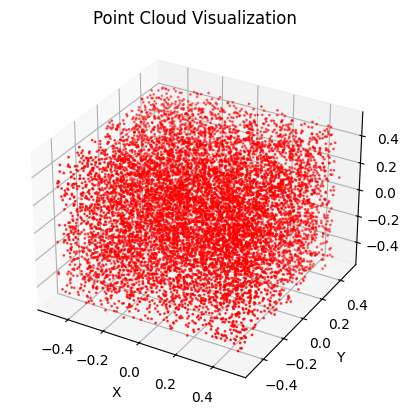

In [31]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Разделение координат на x, y и z
x = points[:, 0]
y = points[:, 1]
z = points[:, 2]

# Отображение точек
ax.scatter(x, y, z, c='r', marker='o', s=1)  # c - цвет, s - размер маркера

# Настройка осей
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Point Cloud Visualization')

plt.show()

In [37]:
def generate_partial_cube(full_points, target_num_points=150):
    # случайно выбираем нужное число точек из полного облака
    if full_points.shape[0] <= target_num_points:
        return full_points
    indices = np.random.choice(full_points.shape[0], target_num_points, replace=False)
    partial_points = full_points[indices]
    return partial_points

partial_cube = generate_partial_cube(full_cube, 5000)
partial_cube.shape

(5000, 3)

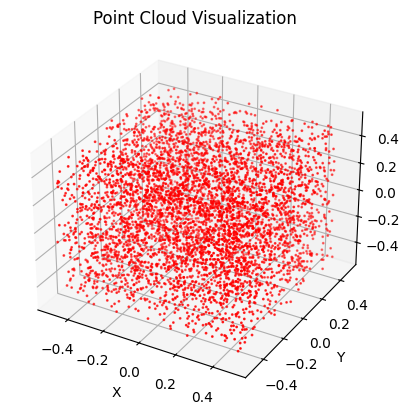

In [38]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Разделение координат на x, y и z
x = partial_cube[:, 0]
y = partial_cube[:, 1]
z = partial_cube[:, 2]

# Отображение точек
ax.scatter(x, y, z, c='r', marker='o', s=1)  # c - цвет, s - размер маркера

# Настройка осей
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Point Cloud Visualization')

plt.show()

In [15]:
import numpy as np

def load_point_cloud(txt_file, num_points=None):
    points = np.loadtxt(txt_file)  # Загружает все точки из файла
    if num_points is not None:
        # Если точек больше, выбираем случайные или первые
        if points.shape[0] >= num_points:
            return points[:num_points]
        else:
            # Если меньше, можно дополнить нулями или дублировать точки
            pad_size = num_points - points.shape[0]
            padding = np.zeros((pad_size, 3))
            return np.concatenate([points, padding], axis=0)
    return points

In [16]:
import os

full_dir = r'A:\ВУЗМАГА\proect bredixin\skypoint'
partial_dir = r'A:\ВУЗМАГА\proect bredixin\broken_skypoint'

full_files = sorted(os.listdir(full_dir))
partial_files = sorted(os.listdir(partial_dir))

# Предположим, что файлы соответствуют по имени или индексу
full_paths = [os.path.join(full_dir, f) for f in full_files]
partial_paths = [os.path.join(partial_dir, f) for f in partial_files]

NUM_POINTS_INPUT = 10000  
NUM_POINTS_OUTPUT = 10000 

In [17]:
full_data = []
partial_data = []

for fp, pp in zip(full_paths, partial_paths):
    full_pc = load_point_cloud(fp, NUM_POINTS_OUTPUT)
    partial_pc = load_point_cloud(pp, NUM_POINTS_INPUT)
    full_data.append(full_pc)
    partial_data.append(partial_pc)

full_data = np.array(full_data)
partial_data = np.array(partial_data)

In [23]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_pointnet_regressor(num_points):
    input_points = layers.Input(shape=(num_points, 3))
    
    # Трансформер признаков (можно добавить более сложные слои)
    x = layers.Conv1D(64, kernel_size=1, activation='relu')(input_points)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(128, kernel_size=1, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(1024, kernel_size=1, activation='relu')(x)
    
    # Глобальный признак
    x = layers.GlobalMaxPooling1D()(x)
    
    # Расширение до формы восстановления
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(num_points * 3)(x)
    
    output_points = layers.Reshape((num_points, 3))(x)
    
    model = models.Model(inputs=input_points, outputs=output_points)
    return model

num_points_full = full_data.shape[1]

model = create_pointnet_regressor(num_points_full)

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 10000, 3)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_24 (Conv1D)              │ (None, 10000, 64)      │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 10000, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_25 (Conv1D)              │ (None, 10000, 128)     │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 10000, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_26 (Conv1D)              │ (None, 10000, 1024)    │       132,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_4          │ (None, 1024)           │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 30000)          │    30,750,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 10000, 3)       │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,945,136 (121.86 MB)

 Trainable params: 31,942,704 (121.85 MB)

 Non-trainable params: 2,432 (9.50 KB)

In [24]:
model.fit(
    full_data,
    partial_data,
    epochs=100,
    batch_size=16,
)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 1555789952.0000
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 1555779840.0000
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 1555765504.0000
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 1555750528.0000
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 1555735168.0000
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 1555720192.0000
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 1555704448.0000
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 1555688320.0000
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 1555670784.0000
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 1555653120.0000
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 1555635968.0000
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 1555617664.0000
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 1555600512.0000
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 155